In [1]:
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import copy, time
import random 
import mfmodel as mfm

from scipy.linalg import pinvh
import mlrfit as mf 
import scipy.linalg as sc_la

/Users/parshakova.tanya/opt/anaconda3/envs/routing/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
np.random.seed(1001)
random.seed(1001)

# True model is MLR factor model with SNR = 4 

Let $\Sigma = FF^T + D$ be MLR. We generate samples using 
$$
y = Fz + e, \qquad z \sim N(0, I), \qquad N(0, D).
$$

In [3]:
mtype = "small_mlr_hier"
n = 200
signal_to_noise = 4


L = 5

ranks = np.array([4, 3, 2, 2, 1])
rank = ranks.sum()


nsamples = 4 * rank

In [4]:
pi_rows = np.random.permutation(n)
hpart = {'rows':{'pi':pi_rows, 'lk':[]}, 'cols':{'pi':pi_rows, 'lk':[]}} 
for ngroups in [2, 5, 17, 33, n+1]:
       hpart['rows']['lk'] += [ np.linspace(0, n, ngroups, endpoint=True, dtype=int)]
hpart['rows']['lk'][1] = np.delete(hpart['rows']['lk'][1], -2)
hpart['rows']['lk'][2] = np.delete(hpart['rows']['lk'][2], -4)
hpart['cols']['lk'] = hpart['rows']['lk']
part_sizes = mfm.print_hpart_numgroups(hpart)

level=0, num_groups=1, mean_size=200.0
level=1, num_groups=3, mean_size=66.7
level=2, num_groups=15, mean_size=13.3
level=3, num_groups=32, mean_size=6.2
level=4, num_groups=200, mean_size=1.0


In [5]:
hpart['rows']['lk'][:-1]

[array([  0, 200]),
 array([  0,  50, 100, 200]),
 array([  0,  12,  25,  37,  50,  62,  75,  87, 100, 112, 125, 137, 150,
        175, 187, 200]),
 array([  0,   6,  12,  18,  25,  31,  37,  43,  50,  56,  62,  68,  75,
         81,  87,  93, 100, 106, 112, 118, 125, 131, 137, 143, 150, 156,
        162, 168, 175, 181, 187, 193, 200])]

In [6]:
true_mlr, true_sparse_F, true_D_noise = mfm.generate_mlr_model(n, hpart, ranks, signal_to_noise)
true_compressed_F = true_mlr.B[:, :-1]

signal_var=11.119582352955492, noise_var=2.8730043099170963
SNR=3.8703674458728394, signal_to_noise=4


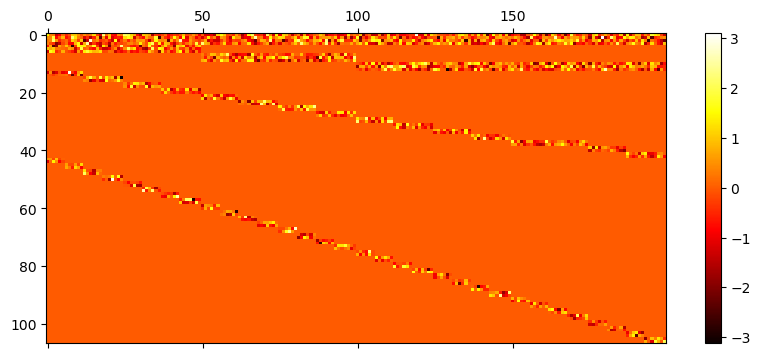

(200, 107)


In [7]:
plt.figure(figsize=(10, 4)) 
plt.matshow(true_sparse_F.T, aspect='auto', fignum=1, cmap='hot') 
plt.colorbar() 
plt.show()
print(true_sparse_F.shape)

In [8]:
type(true_sparse_F)

numpy.ndarray

In [9]:
filename = "%s_r%d_%d"%(mtype, rank, n)

In [10]:
row_selectors, si_groups, F_hpart, groups_all = mfm.row_col_selections(hpart, return_groups=True)

num_levels=5, num_sparsities=32
(32, 4) [ 0  2 14 31]


In [11]:
F_Lm1, D = true_compressed_F+0, true_D_noise+0

In [12]:
s_lps = np.cumsum(np.array([ranks[lp]*(F_hpart['lk'][lp].size - 1) for lp in reversed(range(0, L-1))]))
for l in reversed(range(0, L-1)):
    assert s_lps[l] == sum([ranks[lp]*(F_hpart['lk'][lp].size - 1) for lp in reversed(range(L-2-l, L-1))])

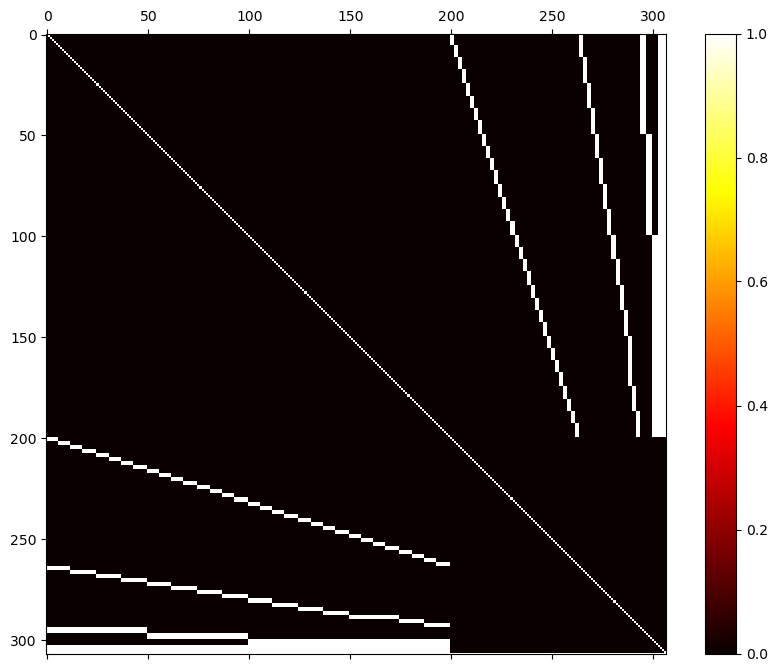

In [13]:
sparse_Fls = np.concatenate([mfm.block_diag_lk(F_hpart['lk'][lp], 
                                            F_Lm1[:, ranks[:lp].sum():ranks[:lp+1].sum()]) 
                                            for lp in reversed(range(0, L-1))], axis=1)
expanded_E = np.block([[np.diag(D), sparse_Fls],
              [sparse_Fls.T, -np.eye(s_lps[-1])]])


plt.figure(figsize=(10, 8)) 
plt.matshow(expanded_E!=0, aspect='auto', fignum=1, cmap='hot') 
plt.colorbar() 
plt.show()

In [14]:
assert np.allclose(true_sparse_F @ true_sparse_F.T, sparse_Fls @ sparse_Fls.T)

In [15]:
for l2 in range(L-1): 
    for l1 in range(l2):
        for l3 in range(l2+1, L-1):
            print(l1, l2, l3)
            lk_1 = F_hpart['lk'][l1]
            lk_2 = F_hpart['lk'][l2]
            lk_3 = F_hpart['lk'][l3]
            F1 = true_compressed_F[:,ranks[:l1].sum():ranks[:l1+1].sum()]
            F2 = true_compressed_F[:,ranks[:l2].sum():ranks[:l2+1].sum()]
            F3 = true_compressed_F[:,ranks[:l3].sum():ranks[:l3+1].sum()]
            
            F2tF1 = mfm.block_diag_lk(lk_2, F2).T @  mfm.block_diag_lk(lk_1, F1)
            res1 = mfm.mult_blockdiag_refined_AtB(F2, lk_2, F1, lk_1)
            # indices of groups in F2 that refine groups in F1
            indices_F2_F1 = np.searchsorted(lk_2, lk_1, side='left') * ranks[l2]
            assert np.allclose(F2tF1, mfm.block_diag_lk(indices_F2_F1, res1)) 


            F2tF3 = mfm.block_diag_lk(lk_2, F2).T @  mfm.block_diag_lk(lk_3, F3)
            res2 = mfm.mult_blockdiag_refined_CtB(F2, lk_2, F3, lk_3)
            # indices of groups in F2 that are refined by groups in F3
            indices_F2_F3 = np.searchsorted(lk_3, lk_2, side='left') * ranks[l3]
            assert np.allclose(F2tF3, mfm.block_diag_lk(indices_F2_F3, res2, col=True)) 

            
            F1_F2_F2t_F3 = F2tF1.T @ F2tF3
            res = mfm.mult_blockdiag_refined_CtB_vh(res1, 
                                                indices_F2_F1,
                                                res2, 
                                                indices_F2_F3)
            indices = np.searchsorted(lk_3, lk_1, side='left') * ranks[l3]
            assert np.allclose(F1_F2_F2t_F3, mfm.block_diag_lk(indices, res, col=True))

print("PASSED")

0 1 2
0 1 3
0 2 3
1 2 3
PASSED


In [16]:
s_all = (ranks * np.array([hpart["rows"]["lk"][level].size-1 for level in range(L)]))[::-1]
s_all

def sparse_chol_row_block(row_block, hpart, level, L, s_all):
    res = []
    for tilde_l in reversed(range(level, L)):
        lk_level_tilde_l = np.searchsorted(hpart["rows"]['lk'][tilde_l], hpart["rows"]['lk'][level], side='left') * ranks[tilde_l]
        res += [mfm.block_diag_lk(lk_level_tilde_l, 
                                  row_block[:, s_all[:L-1-tilde_l].sum():s_all[:L-1-tilde_l+1].sum()], 
                                  col=True)]
    return np.concatenate(res, axis=1)

In [30]:
def lu(A):
    "Compute LU decomposition of matrix A."
    m,n = A.shape
    L = np.eye(m)
    U = A.copy()
    # Keep track of the row index of the pivot entry
    pivot = 0
    for j in range(0,n):
        # Check if the pivot entry is 0
        if U[pivot,j] == 0:
            if np.any(U[pivot+1:,j]):
                # LU decomposition does not exist if entries below 0 pivot are nonzero
                print("LU decomposition for A does not exist.")
                return np.eye(m),A
            else:
                # All entries below 0 pivot are 0 therefore continue to next column
                # Row index of pivot remains the same
                continue
        # Use nonzero pivot entry to create 0 in each entry below
        for i in range(pivot+1,m):
            c = -U[i,j]/U[pivot,j]
            U[i,:] = c*U[pivot,:] + U[i,:]
            L[i,pivot] = -c
        # Move pivot to the next row
        pivot += 1
    return L,U


true_L, true_U = lu(expanded_E)
assert np.allclose(true_L @ true_U, expanded_E)

true_Chol_D = np.diag(true_U)
assert np.allclose((true_L * true_Chol_D) @ true_L.T, expanded_E) 

In [52]:
prev_l_inv_recurrence = (1/D[:, np.newaxis]) * F_Lm1
H_Lm1 = np.zeros(F_Lm1.shape)
L = len(F_hpart['lk']) + 1

# cumulative sums: [p_{L-1} r_{L-1}, ... , p_{L-1} r_{L-1} + ... + p_1 r_1]
s_lps = np.cumsum(np.array([ranks[lp]*(F_hpart['lk'][lp].size - 1) for lp in reversed(range(0, L-1))]))
# for level L size: (r_1 + ... + r_{L-1}) x n
prev_El_recurrence = F_Lm1.T * 1/D[np.newaxis, :]
print(f"{prev_El_recurrence.shape=}")
Chol_L = [np.ones((1, n))] + [None] * (L-1)
# [np.zeros(ranks[lp], n + s_lps[lp]) for lp in reversed(range(0, L-1))]
Chol_D = np.zeros(n + s_lps[L-2])
Chol_D[:n] = D

assert prev_El_recurrence.shape == (ranks[:-1].sum(), n)
for level in reversed(range(0, L-1)):
    pl = F_hpart['lk'][level].size - 1
    rl = ranks[level]
    if rl == 0: continue
    # M0 same sparsity as Fl
    M0 = prev_l_inv_recurrence[:, -ranks[level]:]
    # M1 = M0.T @ rec_term, same sparsity as rec_term
    M1 = np.zeros((rl * pl, ranks[:level].sum()))
    for lp in range(level):
        M1[:, ranks[:lp].sum() : ranks[:lp+1].sum()] = mfm.mult_blockdiag_refined_AtB(M0, 
                                                                            F_hpart['lk'][level], 
                                                                            F_Lm1[:, ranks[:lp].sum():ranks[:lp+1].sum()], 
                                                                            F_hpart['lk'][lp])
    M1_lks = [np.searchsorted(F_hpart['lk'][level], lk_B, side='left') * rl for lk_B in F_hpart['lk'][:level]]

    # M2 = (I + Fl^T M0)^{-1}, blockdiagonal with pl blocks of size (rl x rl)
    FlTM0 = mfm.mult_blockdiag_refined_AtB(F_Lm1[:, ranks[:level].sum() : ranks[:level+1].sum()], 
                                    F_hpart['lk'][level], 
                                    M0, 
                                    F_hpart['lk'][level])

    M2 = np.zeros((pl*rl, rl))
    sqrt_M2 = np.zeros((pl*rl, rl))
    for k in range(pl):
        np.fill_diagonal(FlTM0[k*rl : (k+1)*rl], FlTM0[k*rl : (k+1)*rl].diagonal() + 1)
        eigvals, eigvecs = np.linalg.eigh(FlTM0[k*rl : (k+1)*rl])
        sqrt_M2[k*rl : (k+1)*rl] = ((1 / np.sqrt(eigvals)) * eigvecs) @ eigvecs.T
        M2[k*rl : (k+1)*rl] = ((1/eigvals) * eigvecs) @ eigvecs.T
        del eigvals, eigvecs

    # Cholesky decomposition of M2^{-1}
    Chol_Rl = np.zeros((rl, pl*rl))
    Chol_Vl = np.zeros((pl*rl))
    for k in range(pl):
        Chol_Rl[:, k*rl : (k+1)*rl] = np.linalg.cholesky(FlTM0[k*rl : (k+1)*rl])
        Chol_Vl[k*rl : (k+1)*rl] = np.square(np.diag(Chol_Rl[:, k*rl : (k+1)*rl]))
        Chol_Rl[:, k*rl : (k+1)*rl] *= Chol_Vl[k*rl : (k+1)*rl]**(-1/2)
        assert np.allclose(FlTM0[k*rl : (k+1)*rl], Chol_Rl[:, k*rl : (k+1)*rl] * Chol_Vl[k*rl : (k+1)*rl] @ Chol_Rl[:, k*rl : (k+1)*rl].T)

    # Cholesky new factors L^{(l)}, D^{(l)}
    print(f"{level=}, {L-2-level=}")
    Chol_L[L-1-level] = np.concatenate([prev_El_recurrence[ranks[:level].sum():ranks[:level+1].sum(), :], Chol_Rl], axis=1)
    Chol_D[n + s_lps[L-2-level] - ranks[level]*(F_hpart['lk'][level].size - 1) : n + s_lps[L-2-level]] = -Chol_Vl 
    assert np.allclose(true_L[s_all[:L-1-level].sum():s_all[:L-1-level+1].sum(), :s_all[:L-1-level+1].sum()], 
                       sparse_chol_row_block(Chol_L[L-1-level], hpart, level, L, s_all))


    del FlTM0, Chol_Rl, Chol_Vl
    H_Lm1[:, ranks[:level].sum():ranks[:level+1].sum()] = mfm.mult_blockdiag_refined_AB(M0, 
                                                                                    F_hpart['lk'][level],
                                                                                    sqrt_M2, 
                                                                                    np.linspace(0, pl*rl, num=pl+1, endpoint=True, dtype=int))
    del sqrt_M2
    # M3 = M2 @ M1, same sparsity as M1
    M3 = np.zeros((rl * pl, ranks[:level].sum()))
    for lp in range(level):
        M3[:, ranks[:lp].sum():ranks[:lp+1].sum()] = mfm.mult_blockdiag_refined_AtB(M2, 
                                                                                    np.linspace(0, pl*rl, num=pl+1, endpoint=True, dtype=int), 
                                                                                    M1[:, ranks[:lp].sum():ranks[:lp+1].sum()], 
                                                                                    M1_lks[lp])
    del M1, M2

    if level >= 1:
        old_El_rec = prev_El_recurrence + 0
        # Cholesky recurrent term
        # (r_1 + ... + r_{l-1}) x (n + p_{L-1} r_{L-1} + ... + p_l r_l)
        prev_El_last_rowblock = prev_El_recurrence[-ranks[level]:, :] + 0
        prev_El_recurrence = np.concatenate([prev_El_recurrence[:ranks[:level].sum(), :], M3.T], axis=1)
        El_row_lks = [np.searchsorted(F_hpart['lk'][tilde_l], F_hpart['lk'][level], side='left') * ranks[tilde_l] \
                      for tilde_l in reversed(range(level, L-1))]
        sparse_M3 = mfm.inv_rec_term_to_sparse_H(M3, M1_lks, ranks[:level])
        sparse_row = sparse_chol_row_block(prev_El_last_rowblock, hpart, level, L, s_all)
        res = []
        for l_prime in range(level):
            res_row = []

            tilde_l = L-1 
            rank1, rank2 = ranks[:l_prime].sum(), ranks[:l_prime+1].sum()
            block1, block2 = 0, n
            indices = np.searchsorted(hpart["rows"]['lk'][tilde_l], F_hpart['lk'][level], side='left') * ranks[tilde_l]
            print(f"{tilde_l=}, {l_prime=}", rank1, rank2, block1, block2)
            prod = mfm.mult_blockdiag_refined_CtB_vh(M3[:, rank1 : rank2], 
                                                M1_lks[l_prime],
                                                prev_El_last_rowblock[:, block1: block2], 
                                                indices)
            prev_El_recurrence[rank1 : rank2, block1: block2] = old_El_rec[rank1 : rank2, block1: block2] - prod
            indices = np.searchsorted(hpart["rows"]['lk'][tilde_l], F_hpart['lk'][l_prime], side='left') * ranks[tilde_l]
            res_row += [mfm.block_diag_lk(indices, prod, col=True)]

            for tilde_l in reversed(range(level+1, L-1)):
                rank1, rank2 = ranks[:l_prime].sum(), ranks[:l_prime+1].sum()
                if tilde_l == L-1:
                    block1, block2 = 0, n
                else:
                    block1, block2 = n + s_lps[L-2-tilde_l] - ranks[tilde_l]*(F_hpart['lk'][tilde_l].size - 1), \
                                 n + s_lps[L-2-tilde_l]
                print(f"{tilde_l=}, {l_prime=}", rank1, rank2, block1, block2)
                prod = mfm.mult_blockdiag_refined_CtB_vh(M3[:, rank1 : rank2], 
                                                M1_lks[l_prime],
                                                prev_El_last_rowblock[:, block1: block2], 
                                                El_row_lks[L-2-tilde_l])
                prev_El_recurrence[rank1 : rank2, block1: block2] = old_El_rec[rank1 : rank2, block1: block2] - prod
                indices = np.searchsorted(F_hpart['lk'][tilde_l], F_hpart['lk'][l_prime], side='left') * ranks[tilde_l]
                res_row += [mfm.block_diag_lk(indices, prod, col=True)]

            if res_row:  
                res += [np.concatenate(res_row, axis=1)]
        if res:      
            assert np.allclose(sparse_M3.T @ sparse_row, np.concatenate(res, axis=0))
            print("passed")
                

    # M4 = M0 @ M3, same sparsity as current rec_term
    M4 = np.zeros((n, ranks[:level].sum()))
    for lp in range(level):
        M4[:, ranks[:lp].sum() : ranks[:lp+1].sum()] = mfm.mult_blockdiag_refined_AB(M0, 
                                                                                    F_hpart["lk"][level], 
                                                                                    M3[:, ranks[:lp].sum():ranks[:lp+1].sum()], 
                                                                                    M1_lks[lp])
    del M0, M3

    # M5  
    prev_l_inv_recurrence = prev_l_inv_recurrence[:, :ranks[:level].sum()] - M4
    del M4

    if level >= 1:
        # Cholesky recurrent term
        assert np.allclose(prev_El_recurrence[:, :n], prev_l_inv_recurrence.T)
        print("passed")
        prev_El_recurrence[:, :n] = prev_l_inv_recurrence.T
        assert prev_El_recurrence.shape == (ranks[:level].sum(), n + s_lps[L-2-level])

prev_El_recurrence.shape=(11, 200)
level=3, L-2-level=0
tilde_l=4, l_prime=0 0 4 0 200
tilde_l=4, l_prime=1 4 7 0 200
tilde_l=4, l_prime=2 7 9 0 200
passed
passed
level=2, L-2-level=1


AssertionError: 

In [51]:
prev_El_recurrence[ranks[:level].sum():ranks[:level+1].sum(), :].shape

(2, 200)

In [18]:
sparse_Chol_L = np.zeros((n + s_lps[-1], n + s_lps[-1]))

In [19]:
for level in reversed(range(L)):

    sparse_Chol_L[s_all[:L-1-level].sum():s_all[:L-1-level+1].sum(), :s_all[:L-1-level+1].sum()] = sparse_chol_row_block(Chol_L[L-1-level], 
                                                                                                                         hpart, level, L, s_all)

    assert np.allclose(sparse_Chol_L, np.tril(sparse_Chol_L)), print(f"{level=}, {tilde_l=}")

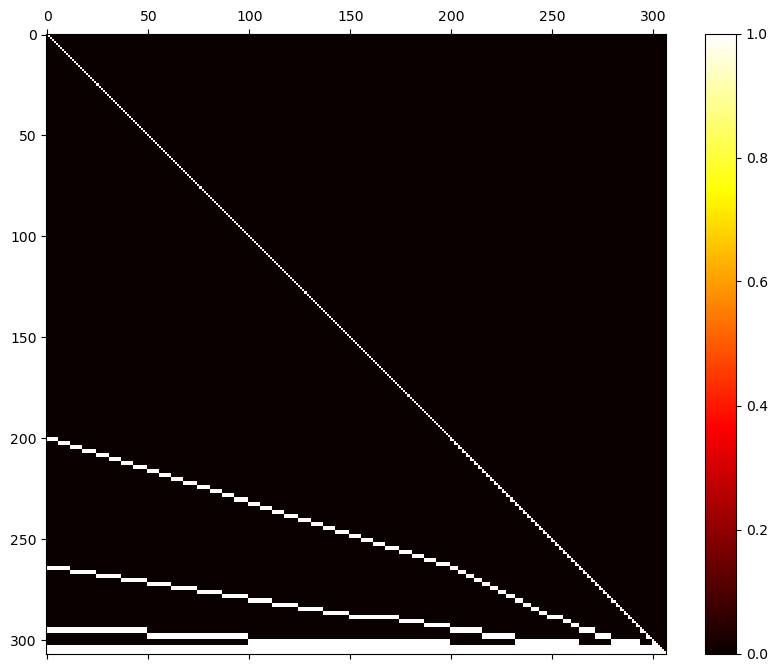

In [20]:
plt.figure(figsize=(10, 8)) 
plt.matshow(np.abs(sparse_Chol_L)[:]!=0, aspect='auto', fignum=1, cmap='hot') 
plt.colorbar() 
plt.show()

In [21]:
print(mf.rel_diff(expanded_E, (sparse_Chol_L @  np.diag(Chol_D)) @ sparse_Chol_L.T))
assert (Chol_D > 0).sum() == n
assert np.allclose(expanded_E, (sparse_Chol_L * Chol_D) @ sparse_Chol_L.T)

3.1521937233239696


AssertionError: 

In [24]:
assert np.allclose(true_Chol_D, Chol_D)

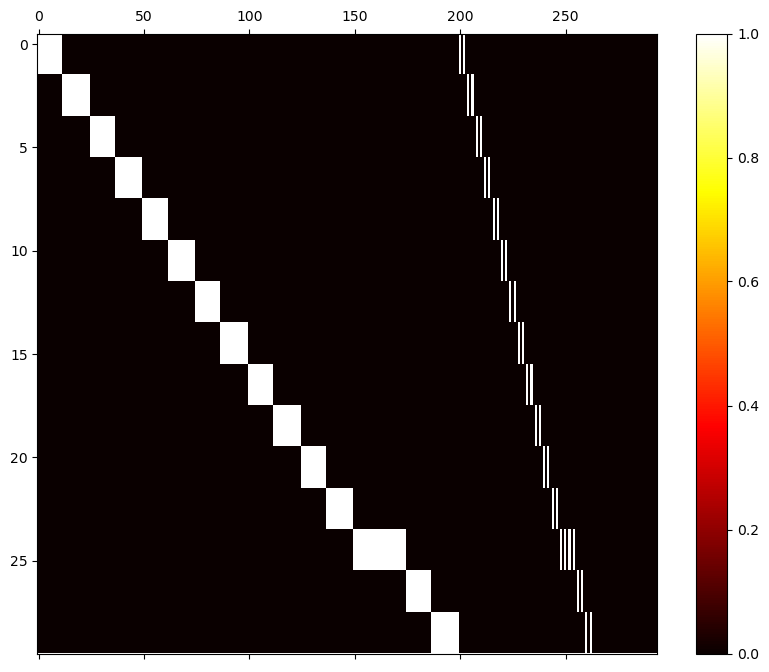

In [40]:
diff = true_L[s_all[:L-1-level].sum():s_all[:L-1-level+1].sum(), :s_all[:L-1-level+1].sum()] -sparse_chol_row_block(Chol_L[L-1-level], hpart, level, L, s_all)

plt.figure(figsize=(10, 8)) 
plt.matshow(np.abs(diff)>1e-8, aspect='auto', fignum=1, cmap='hot') 
plt.colorbar() 
plt.show()

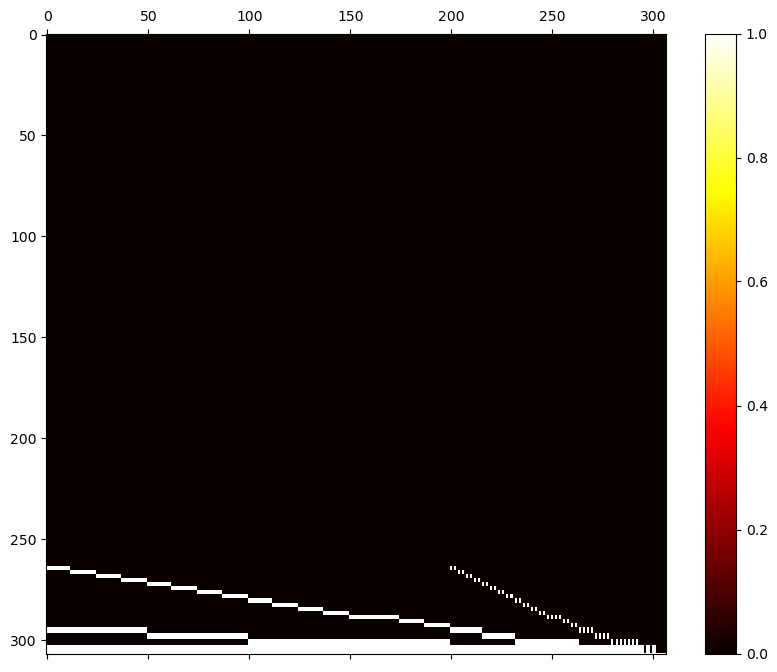

In [26]:
plt.figure(figsize=(10, 8)) 
plt.matshow(np.abs(true_L - sparse_Chol_L)>1e-8, aspect='auto', fignum=1, cmap='hot') 
plt.colorbar() 
plt.show()

In [27]:
((np.abs(true_L)>1e-8).astype(int) - (np.abs(sparse_Chol_L)>1e-8).astype(int)).sum()

0